In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from hydroeval import evaluator, rmse, kge

# Helpers
def mbe(sim, obs):
    diff = sim - obs
    valid = ~np.isnan(diff)
    if np.any(valid):
        return np.nanmean(diff)
    else:
        return np.nan

def r2(sim, obs):
    corr_matrix = np.corrcoef(sim, obs)
    corr = corr_matrix[0,1]
    return corr**2

In [2]:
sim = pd.read_csv("monthly_ppe_ensembles_data.csv")
obs_def = pd.read_csv("NEON_and_CLM5_Default.csv", parse_dates=['Time'], index_col='Time')

In [3]:
sites = ["TALL", "OSBS", "ORNL"]
vars = {"GPP": "GPP", "EFLX_LH_TOT": "EFLX_LH_TOT"}

# Filter out bad ensembles per site
low_sets = {}
for site in sites:
    col = f"{site}_GPP"
    flagged = (
        sim.groupby("Ensemble")[col]
        .apply(lambda x: (x == 0).all() or (x.mean() < 1))
    )
    low_sets[site] = set(flagged[flagged].index)

In [4]:
# The analysis workflow
results = []
for ens, g in sim.groupby("Ensemble"):
    for site in sites:
        if ens in low_sets[site]: # skip if ensemble is "bad" [contains all zeros]
            continue  
        for var, vname in vars.items():
            simcol = f"{site}_{vname}"
            obcol  = f"{site}_NEON_{vname}"
            if obcol not in obs_def.columns or simcol not in g.columns:
                continue
            g["Time"] = pd.to_datetime(g["Time"]).dt.to_period("M").dt.to_timestamp()
            obs_def.index = pd.to_datetime(obs_def.index).to_period("M").to_timestamp()
            common_months = g["Time"].isin(obs_def.index)
            g = g.loc[common_months]

            svals = g[simcol].values
            ovals = obs_def[obcol].reindex(g["Time"]).values

            mask = ~np.isnan(ovals) # mask out missing NEON observations
            if mask.sum() == 0:
                continue

            svals = svals[mask]
            ovals = ovals[mask]

            rmse_val = float(np.ravel(evaluator(rmse, svals, ovals))[0])
            mbe_val  = mbe(svals, ovals)
            r2_val   = r2(svals, ovals)
            kge_val  = float(np.ravel(evaluator(kge, svals, ovals))[0])

            results.append([ens, site, var, rmse_val, mbe_val, r2_val, kge_val])
dfres = pd.DataFrame(results, columns=["Ensemble","Site","Var","RMSE","MBE","R2","KGE"])
metrics_df = (dfres.set_index(["Ensemble","Site","Var"]).unstack(["Site","Var"]))
metrics_df.columns = [f"{site}_{var}_{metric}" for metric, site, var in metrics_df.columns]
metrics_df = metrics_df.reset_index()

In [5]:
obs_means = {
    f"{site}_{vname}": np.nanmean(obs_def[f"{site}_NEON_{vname}"].values)
    for site in sites
    for var, vname in vars.items()
    if f"{site}_NEON_{vname}" in obs_def.columns
}

# Normalize RMSE and MBE
for key in obs_means:
    for metric in ["RMSE", "MBE"]:
        col = f"{key}_{metric}"
        if col in metrics_df.columns:
            vals = metrics_df[col].abs() if metric == "MBE" else metrics_df[col]
            min_val, max_val = vals.min(), vals.max()
            metrics_df[f"{key}_{metric}_norm"] = 1 - (vals - min_val) / (max_val - min_val)

# Composite metric per variable
for key in obs_means:
    cols = [f"{key}_R2", f"{key}_RMSE_norm", f"{key}_MBE_norm"]
    if all(c in metrics_df.columns for c in cols):
        metrics_df[f"{key}_Mcomposite_var"] = metrics_df[cols].mean(axis=1)

# Composite per site (GPP + ET)
for site in sites:
    gpp = f"{site}_GPP_Mcomposite_var"
    et  = f"{site}_EFLX_LH_TOT_Mcomposite_var"
    if gpp in metrics_df.columns and et in metrics_df.columns:
        metrics_df[f"{site}_Mcomposite"] = metrics_df[[gpp, et]].mean(axis=1)

In [6]:
# Figure 5 plotting helpers
def get_aligned_monthly(obs_series, sim_df, site, var, ensemble):
    simcol = f"{site}_{var}"
    df_sim = sim_df.query("Ensemble == @ensemble")[["Time", simcol]].copy()
    df_sim["Time"] = pd.to_datetime(df_sim["Time"])
    df_sim.set_index("Time", inplace=True)

    obs_df = obs_series.copy().to_frame("Obs")
    obs_df.index = pd.to_datetime(obs_df.index)

    return obs_df.join(df_sim, how="inner").rename(columns={simcol: "Sim"})

def get_top10_envelope(obs_series, sim_df, site, var, ensembles):
    simcol = f"{site}_{var}"
    obs_df = obs_series.copy().to_frame("Obs")
    obs_df.index = pd.to_datetime(obs_df.index)

    df_sims = pd.concat([
        sim_df.query("Ensemble == @ens")[["Time", simcol]].assign(Time=lambda x: pd.to_datetime(x["Time"]))
        .set_index("Time")[[simcol]].rename(columns={simcol: ens})
        for ens in ensembles
    ], axis=1)

    return pd.concat([
        obs_df,
        df_sims.min(axis=1).rename("Top10_min"),
        df_sims.max(axis=1).rename("Top10_max")
    ], axis=1).dropna()

#### Figure 5

In [7]:
def plot_site(ax, site, var, obs, def_vals, best_vals, top10_min, top10_max):
    mask = ~np.isnan(obs) & ~np.isnan(def_vals) & ~np.isnan(best_vals)
    obs, def_vals, best_vals = obs[mask], def_vals[mask], best_vals[mask]
    top10_min, top10_max = top10_min[mask], top10_max[mask]

    sort_idx = np.argsort(obs)
    obs_sorted = obs[sort_idx]

    ax.scatter(obs, def_vals, facecolors="none", edgecolors="red", marker="o")
    ax.scatter(obs, best_vals, facecolors="none", edgecolors="blue", marker="v")
    ax.plot(obs_sorted, obs_sorted, "k-", lw=2, label="1:1")

    for vals, color, label in [(def_vals, "r-", "Def"), (best_vals, "b-", "PPE")]:
        s, i = np.polyfit(obs, vals, 1)
        r2 = np.corrcoef(obs, vals)[0, 1] ** 2
        ax.plot(obs_sorted, s * obs_sorted + i, color, lw=1.5, label=f"{label}: R²={r2:.2f}")

    smin, imin = np.polyfit(obs, top10_min, 1)
    smax, imax = np.polyfit(obs, top10_max, 1)
    ax.fill_between(obs_sorted, smin * obs_sorted + imin, smax * obs_sorted + imax,
                    color="grey", alpha=0.5)

    units = {
        "GPP": "[g C m$^{-2}$ day$^{-1}$]",
        "ET": "[W m$^{-2}$]"
    }
    ax.set_xlabel(f"NEON {var} {units[var]}", fontsize=12)
    ax.set_ylabel(f"CLM5 {var} {units[var]}", fontsize=12)
    ax.set_title(f"{site} {var}")
    ax.legend(loc="upper left", fontsize=9)

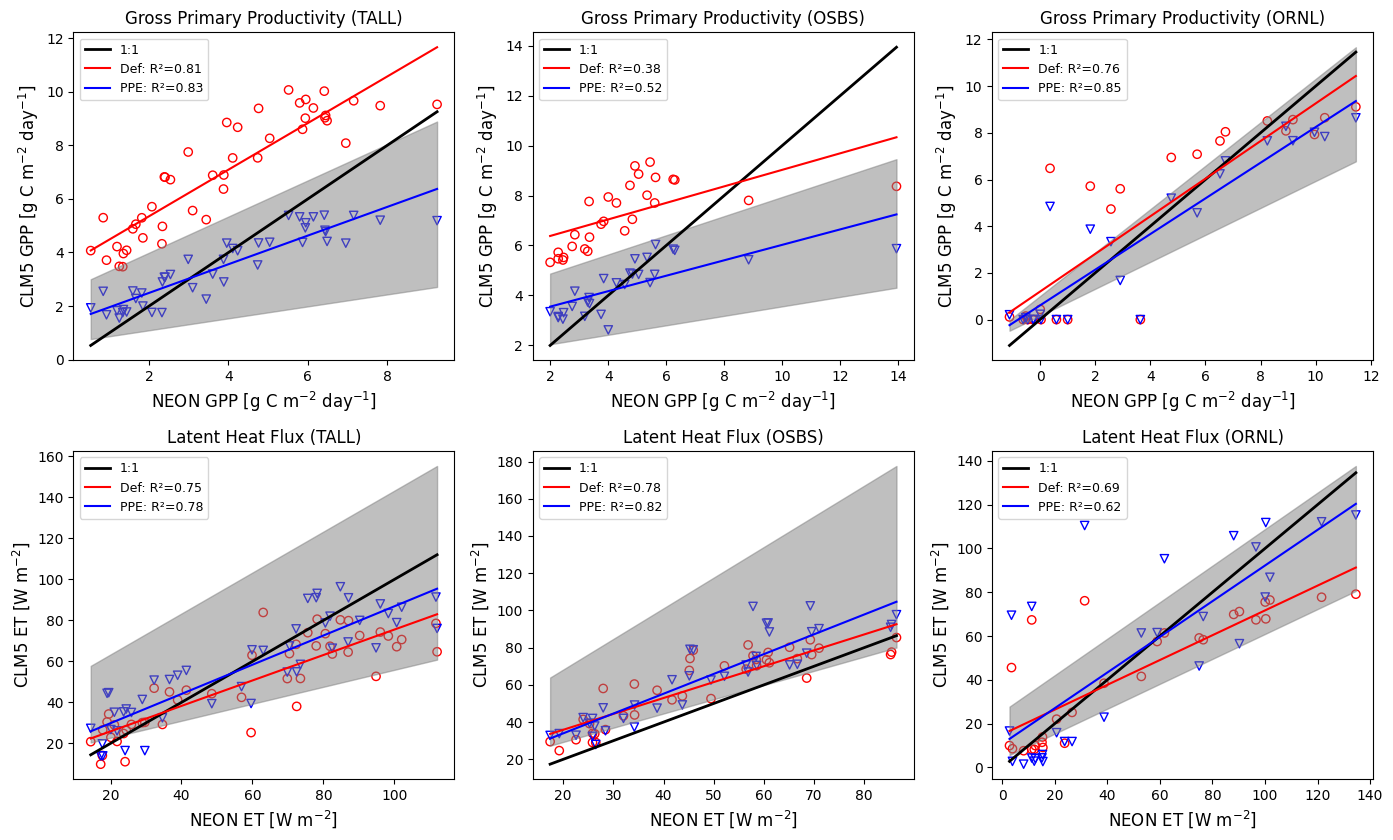

In [8]:
fig, axs = plt.subplots(2, 3, figsize=(14, 8.5))
sites = ["TALL", "OSBS", "ORNL"]
vars = ["GPP", "EFLX_LH_TOT"]
titles = [
    'Gross Primary Productivity (TALL)', 'Gross Primary Productivity (OSBS)', 'Gross Primary Productivity (ORNL)',
    'Latent Heat Flux (TALL)', 'Latent Heat Flux (OSBS)', 'Latent Heat Flux (ORNL)'
]

for j, site in enumerate(sites):
    ranked = metrics_df.sort_values(f"{site}_Mcomposite", ascending=False)
    best_ens = ranked.iloc[0]["Ensemble"]
    if best_ens == "LHC0000":
        best_ens = ranked.iloc[1]["Ensemble"]
    top10 = [ens for ens in ranked.head(int(len(ranked) * 0.1))["Ensemble"] if ens != "LHC0000"]

    for i, var in enumerate(vars):
        var_label = "GPP" if var == "GPP" else "ET"
        obs_series = obs_def[f"{site}_NEON_{var}"]
        df_def = get_aligned_monthly(obs_series, sim, site, var, "LHC0000")
        df_best = get_aligned_monthly(obs_series, sim, site, var, best_ens)
        df_env = get_top10_envelope(obs_series, sim, site, var, top10)

        common = df_def.index.intersection(df_best.index).intersection(df_env.index)
        obs_vals = df_env.loc[common, "Obs"].values
        def_vals = df_def.loc[common, "Sim"].values
        best_vals = df_best.loc[common, "Sim"].values
        top10_min = df_env.loc[common, "Top10_min"].values
        top10_max = df_env.loc[common, "Top10_max"].values

        ax = axs[i, j]
        plot_site(ax, site, var_label, obs_vals, def_vals, best_vals, top10_min, top10_max)
        ax.set_title(titles[j + 3 * i], fontsize=12)

plt.tight_layout()
plt.savefig('fig_5.png', dpi=300, bbox_inches='tight')
plt.show()

#### Figure 6

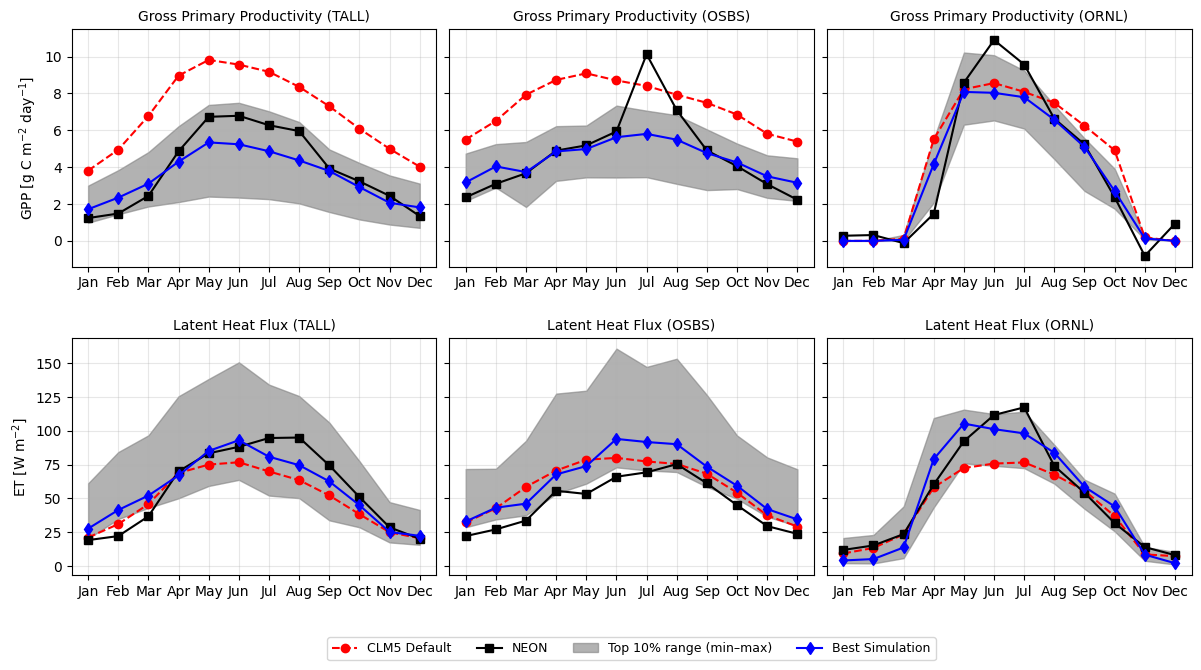

In [9]:
sites = ['TALL', 'OSBS', 'ORNL']
variables = ['GPP', 'EFLX_LH_TOT']
titles = [f'{vname} ({site})' for vname in ['Gross Primary Productivity', 'Latent Heat Flux'] for site in sites]
month_labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

ptal, posbs, pornl, best_dict = [], [], [], {}

for site in sites:
    ranked = metrics_df.sort_values(f"{site}_Mcomposite", ascending=False)
    top10 = [e for e in ranked.head(int(len(ranked) * 0.1))["Ensemble"] if e != "LHC0000"]
    if site == "TALL": ptal = top10
    elif site == "OSBS": posbs = top10
    else: pornl = top10
    best_ens = ranked.iloc[0]["Ensemble"]
    best_dict[site] = ranked.iloc[1]["Ensemble"] if best_ens == "LHC0000" else best_ens

def process_site_with_time(df, site, best_ens):
    df = df[['Time','Ensemble',f'{site}_EFLX_LH_TOT',f'{site}_GPP']].copy()
    df['Month'] = pd.to_datetime(df['Time']).dt.month
    mavg = df.groupby(['Ensemble','Month']).mean(numeric_only=True).reset_index()
    return mavg[mavg['Ensemble']==best_ens].copy(), mavg

top10_dict = {
    'TALL': sim[sim['Ensemble'].isin(ptal)],
    'OSBS': sim[sim['Ensemble'].isin(posbs)],
    'ORNL': sim[sim['Ensemble'].isin(pornl)]
}
best_data, top10_data = {}, {}
for s in sites:
    best_data[s], top10_data[s] = process_site_with_time(top10_dict[s], s, best_dict[s])

line_styles = {
    "CLM":  {"color":"red","marker":"o","linestyle":"--","label":"CLM5 Default"},
    "NEON": {"color":"black","marker":"s","linestyle":"-","label":"NEON"},
    "Best": {"color":"blue","marker":"d","linestyle":"-","label":"Best Simulation"},
    "MODIS":{"color":"green","marker":"^","linestyle":"-","label":"MODIS"},
}

fig, axis = plt.subplots(2, 3, figsize=(14,7), sharey='row')

for i, site in enumerate(sites):
    for j, var in enumerate(variables):
        ax = axis[j, i]
        obs_df = obs_def[[f"{site}_NEON_{var}", f"{site}_CLM_{var}"]].copy()
        obs_df.index = pd.to_datetime(obs_df.index)
        obs_df["Month"] = obs_df.index.month
        seasonal = obs_df.groupby("Month").mean(numeric_only=True)

        months = np.arange(1, 13)
        ax.plot(months, seasonal[f"{site}_CLM_{var}"], **line_styles["CLM"])
        ax.plot(months, seasonal[f"{site}_NEON_{var}"], **line_styles["NEON"])

        g = top10_data[site].groupby('Month')[f'{site}_{var}']
        ax.fill_between(months, g.min(), g.max(), color='gray', alpha=0.6, label='Top 10% range (min–max)')
        ax.plot(best_data[site]['Month'], best_data[site][f'{site}_{var}'], **line_styles["Best"])

        ax.set_title(f"{'Gross Primary Productivity' if j==0 else 'Latent Heat Flux'} ({site})", fontsize=10)
        if i==0: ax.set_ylabel("GPP [g C m$^{-2}$ day$^{-1}$]" if j==0 else "ET [W m$^{-2}$]")
        ax.set_xticks(range(1,13)); ax.set_xticklabels(month_labels)
        ax.grid(alpha=0.3)

handles, labels = axis[0,2].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5,-0.01), fontsize=9, ncol=6)
fig.set_facecolor('white')
plt.subplots_adjust(left=0.1, bottom=0.12, right=0.9, top=0.9, wspace=0.035, hspace=0.30)
plt.savefig("fig_6.png", dpi=300, bbox_inches="tight")
plt.show()

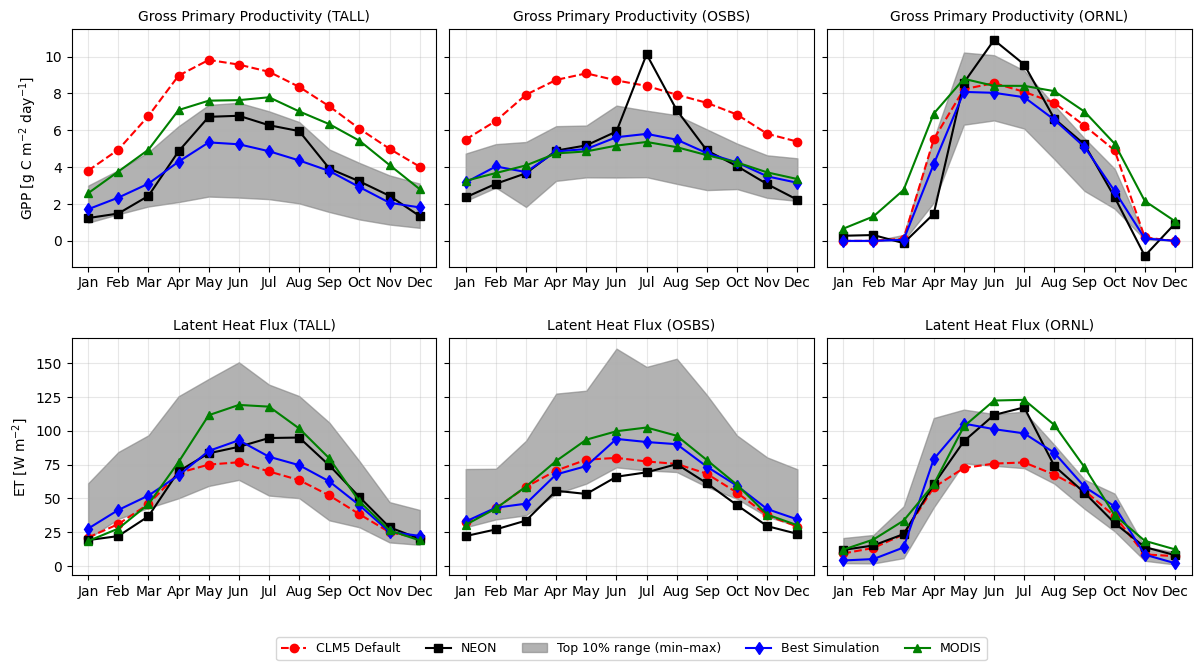

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

modis_gpp = pd.read_csv("GPP_MODIS.csv", parse_dates=["date"]).set_index("date")
modis_et  = pd.read_csv("et_MODIS.csv",  parse_dates=["date"]).set_index("date")
for df in [modis_gpp, modis_et]: df["Month"] = df.index.month
seasonal_mean = lambda df, col: df.groupby("Month")[col].mean()

fig, axis = plt.subplots(2, 3, figsize=(14,7), sharey='row')
variables = ['GPP','EFLX_LH_TOT']
month_labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

for i, site in enumerate(sites):
    for j, var in enumerate(variables):
        ax = axis[j,i]
        obs_df = obs_def[[f"{site}_NEON_{var}", f"{site}_CLM_{var}"]].copy()
        obs_df.index = pd.to_datetime(obs_df.index)
        obs_df["Month"] = obs_df.index.month
        seasonal = obs_df.groupby("Month").mean(numeric_only=True)

        months = np.arange(1,13)
        ax.plot(months, seasonal[f"{site}_CLM_{var}"], **line_styles["CLM"])
        ax.plot(months, seasonal[f"{site}_NEON_{var}"], **line_styles["NEON"])

        g = top10_data[site].groupby('Month')[f'{site}_{var}']
        ax.fill_between(months, g.min(), g.max(), color='gray', alpha=0.6, label='Top 10% range (min–max)')
        ax.plot(best_data[site]['Month'], best_data[site][f'{site}_{var}'], **line_styles["Best"])

        if var == "GPP":   ax.plot(months, seasonal_mean(modis_gpp, site), **line_styles["MODIS"])
        if var == "EFLX_LH_TOT": ax.plot(months, seasonal_mean(modis_et, site), **line_styles["MODIS"])

        ax.set_title(f"{'Gross Primary Productivity' if j==0 else 'Latent Heat Flux'} ({site})", fontsize=10)
        if i==0: ax.set_ylabel("GPP [g C m$^{-2}$ day$^{-1}$]" if j==0 else "ET [W m$^{-2}$]")
        ax.set_xticks(range(1,13)); ax.set_xticklabels(month_labels)
        ax.grid(alpha=0.3)

handles, labels = axis[0,2].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5,-0.01), fontsize=9, ncol=7)
fig.set_facecolor('white')
plt.subplots_adjust(left=0.1,bottom=0.12,right=0.9,top=0.9,wspace=0.035,hspace=0.30)
plt.savefig("fig_6_NEON_vs_MODIS.png", dpi=300, bbox_inches="tight")
plt.show()

#### Figure 7

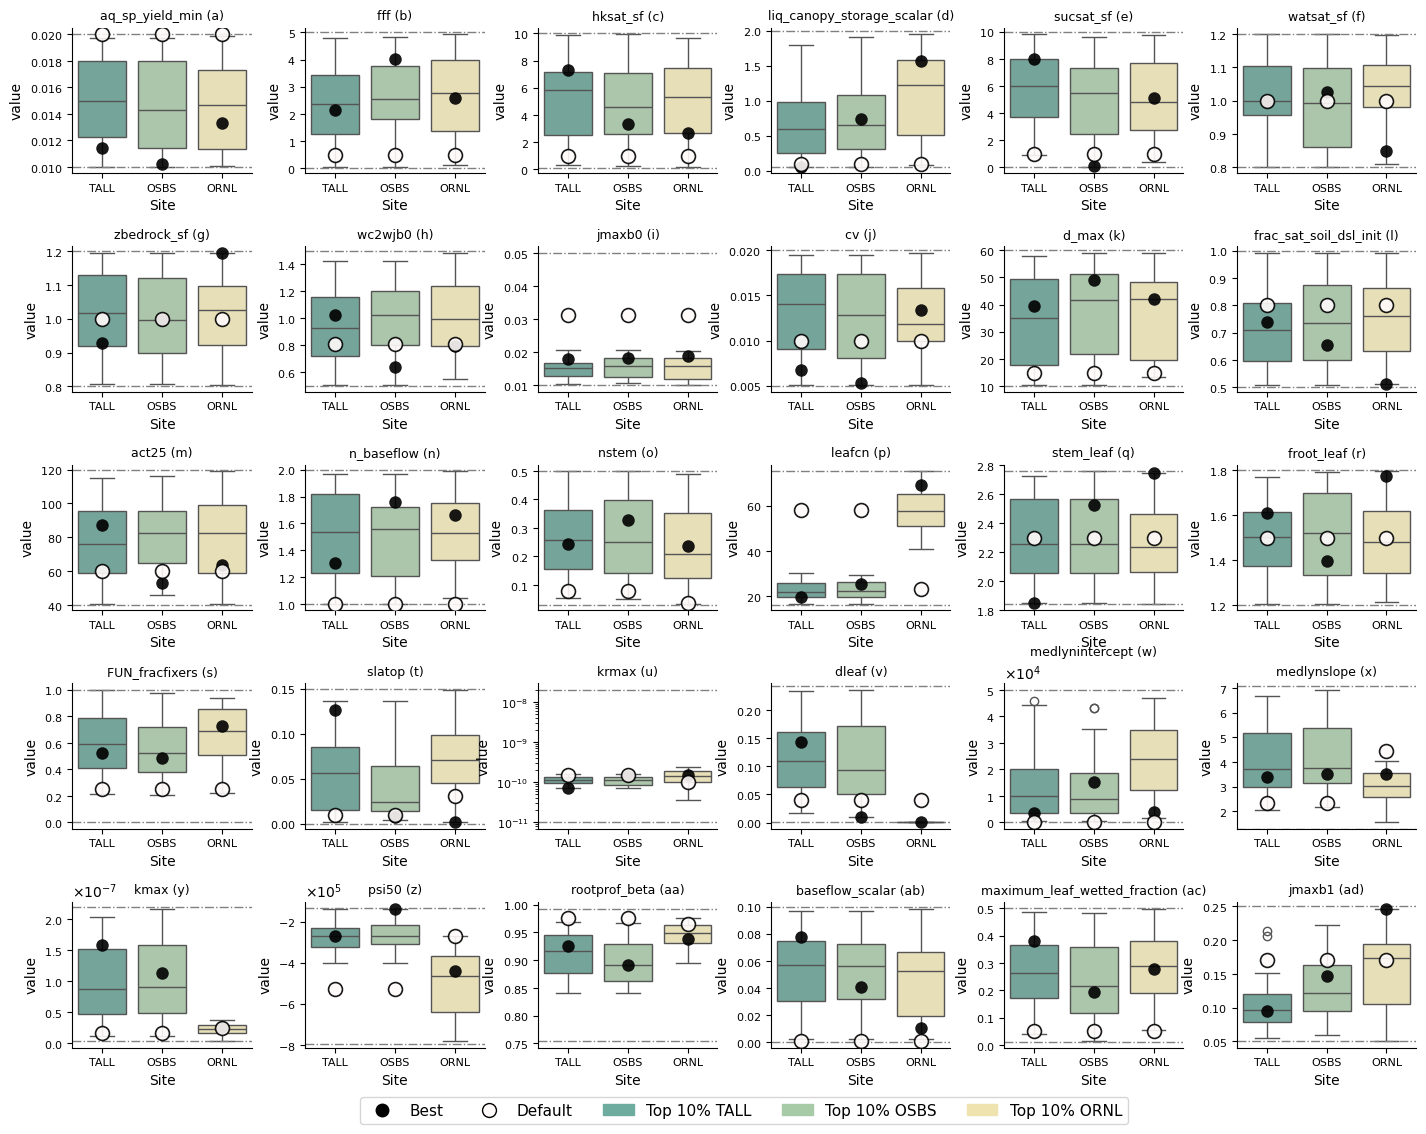

In [8]:
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt, string, matplotlib.patches as mpatches
from matplotlib.ticker import ScalarFormatter

pft1    = pd.read_csv("revised_param_pft_1.csv")
pft7    = pd.read_csv("revised_param_pft_7.csv")
default = pd.read_csv("default_rev.csv")
min_max = pd.read_csv("min_max.csv")

# helpers
def get_best_top10(df, site_col):
    ranked = df[['Ensemble', site_col]].dropna().sort_values(site_col, ascending=False)
    best = ranked.iloc[1] if ranked.iloc[0]['Ensemble'] == "LHC0000" else ranked.iloc[0]
    top10 = ranked.iloc[:max(1, int(0.1 * len(ranked)))]
    return best, top10

def extract_params(ensembles, pft_df, site):
    out = pft_df[pft_df['Ensemble'].isin(ensembles)].copy()
    out["Site"] = site
    return out

# The best and top10% per site
best_tall, top10_tall = get_best_top10(metrics_df, 'TALL_Mcomposite')
best_osbs, top10_osbs = get_best_top10(metrics_df, 'OSBS_Mcomposite')
best_ornl, top10_ornl = get_best_top10(metrics_df, 'ORNL_Mcomposite')

# Extracting parameter sets
best_params = pd.concat([
    extract_params([best_tall['Ensemble']], pft1, "TALL"),
    extract_params([best_osbs['Ensemble']], pft1, "OSBS"),
    extract_params([best_ornl['Ensemble']], pft7, "ORNL")
])
top10_params = pd.concat([
    extract_params(top10_tall['Ensemble'], pft1, "TALL"),
    extract_params(top10_osbs['Ensemble'], pft1, "OSBS"),
    extract_params(top10_ornl['Ensemble'], pft7, "ORNL")
])

df          = top10_params.melt(id_vars=["Ensemble","Site"], var_name="param", value_name="value")
best_long   = best_params.melt(id_vars=["Ensemble","Site"], var_name="param", value_name="value")
default_long= default.melt(id_vars="Site", var_name="param", value_name="value")
min_dict = min_max.set_index("State").T.to_dict()

site_order  = ["TALL", "OSBS", "ORNL"]
site_colors = {"TALL":"#6DAC9E", "OSBS":"#A7CBA7", "ORNL":"#EFE4B0"}
params      = [c for c in pft1.columns if c != "Ensemble"]
labels      = list(string.ascii_lowercase) + [f'a{l}' for l in string.ascii_lowercase[:10]]


fig, axes = plt.subplots(5, 6, figsize=(16,12))
for i, (param, ax) in enumerate(zip(params, axes.flatten())):
    sns.boxplot(ax=ax, x="Site", y="value", data=df[df["param"]==param],
                order=site_order, hue="Site", palette=site_colors, legend=False)
    sns.stripplot(ax=ax, x="Site", y="value", data=best_long[best_long["param"]==param],
                  order=site_order, color='black', size=9, alpha=0.9, edgecolor='black')
    sns.stripplot(ax=ax, x="Site", y="value", data=default_long[default_long["param"]==param],
                  order=site_order, color='snow', size=10, alpha=0.9, edgecolor='black', linewidth=1.2)
    ax.set_title(f"{param} ({labels[i]})", fontsize=9)
    ax.tick_params(labelsize=8)
    ax.spines[['right','top']].set_visible(False)
    if param == "krmax":
        ax.set_yscale("log")
    else:
        ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.ticklabel_format(style='scientific', axis='y', scilimits=(-3,3))
    ax.axhline(min_dict["min"][param], linestyle='dashdot', color='grey', linewidth=1)
    ax.axhline(min_dict["max"][param], linestyle='dashdot', color='grey', linewidth=1)

for j in range(len(params), len(axes.flatten())):
    fig.delaxes(axes.flatten()[j])
legend_items = [
    plt.Line2D([0],[0], marker='o', color='w', markerfacecolor='black', markeredgecolor='black',
               markersize=9, label="Best"),
    plt.Line2D([0],[0], marker='o', color='w', markerfacecolor='snow', markeredgecolor='black',
               markersize=10, label="Default")
]
for site, color in site_colors.items():
    legend_items.append(mpatches.Patch(color=color, label=f"Top 10% {site}"))

fig.legend(handles=legend_items, loc='lower center', bbox_to_anchor=(0.5,0.03),
           ncol=5, prop={'size':11}, markerscale=1)

plt.subplots_adjust(left=0.08, right=0.92, top=0.95, bottom=0.1, hspace=0.5, wspace=0.3)
plt.savefig("Figure_7.png", dpi=300, bbox_inches="tight")
plt.show()

#### Figure 10

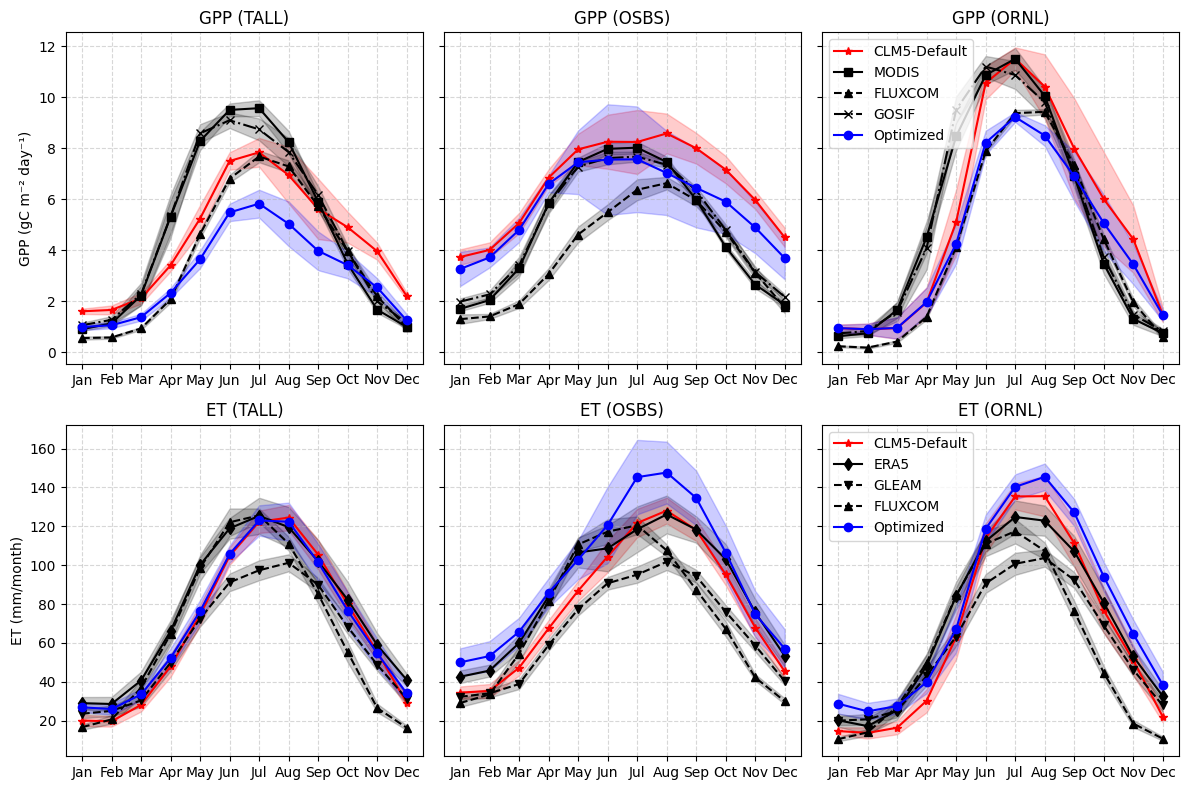

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
gpp_df = pd.read_csv("regional_gpp_dataset.csv", parse_dates=['time'], index_col='time')
et_df = pd.read_csv("regional_et_dataset.csv", parse_dates=['time'], index_col='time')

line_styles = {
    "DEF": {"color": "red", "linestyle": "-", "marker": "*", "label": "CLM5-Default"},
    "MODIS": {"color": "black", "linestyle": "-", "marker": "s", "label": "MODIS"},
    "FLUXCOM": {"color": "black", "linestyle": "--", "marker": "^", "label": "FLUXCOM"},
    "GOSIF": {"color": "black", "linestyle": "-.", "marker": "x", "label": "GOSIF"},
    "ERA5": {"color": "black", "linestyle": "-", "marker": "d", "label": "ERA5"},
    "GLEAM": {"color": "black", "linestyle": "--", "marker": "v", "label": "GLEAM"},
    "OSBS": {"color": "blue", "linestyle": "-", "marker": "o", "label": "Optimized"},
    "TALL": {"color": "blue", "linestyle": "-", "marker": "o", "label": "Optimized"},
    "ORNL": {"color": "blue", "linestyle": "-", "marker": "o", "label": "Optimized"}
}

def get_style(col):
    for key in line_styles:
        if key in col:
            return line_styles[key]
    raise ValueError(f"No style found for column: {col}")

monthly_mean_gpp = gpp_df.groupby(gpp_df.index.month).mean()
monthly_std_gpp  = gpp_df.groupby(gpp_df.index.month).std()

gpp_ecoregion_cols = {
    "TALL": ["DEF_TALL", "MODIS_TALL", "FLUXCOM_TALL", "GOSIF_TALL", "CAL_TALL"],
    "OSBS": ["DEF_OSBS", "MODIS_OSBS", "FLUXCOM_OSBS", "GOSIF_OSBS", "CAL_OSBS"],
    "ORNL": ["DEF_ORNL", "MODIS_ORNL", "FLUXCOM_ORNL", "GOSIF_ORNL", "CAL_ORNL"]
}

monthly_mean_et = et_df.groupby(et_df.index.month).mean()
monthly_std_et  = et_df.groupby(et_df.index.month).std()

et_ecoregion_cols = {
    "TALL": ["DEF_TALL", "ERA5_TALL", "GLEAM_TALL", "FLUXCOM_TALL", "CAL_TALL"],
    "OSBS": ["DEF_OSBS", "ERA5_OSBS", "GLEAM_OSBS", "FLUXCOM_OSBS", "CAL_OSBS"],
    "ORNL": ["DEF_ORNL", "ERA5_ORNL", "GLEAM_ORNL", "FLUXCOM_ORNL", "CAL_ORNL"]
}
months = range(1, 13)
month_labels = ["Jan","Feb","Mar","Apr","May","Jun",
                "Jul","Aug","Sep","Oct","Nov","Dec"]

fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharey = 'row')
gpp_axes = axes[0, :] 
et_axes  = axes[1, :]
for ax in gpp_axes[1:]:
    ax.sharey(gpp_axes[0])
for ax in et_axes[1:]:
    ax.sharey(et_axes[0])

for ax, (eco, cols) in zip(axes[0, :], gpp_ecoregion_cols.items()):
    for col in cols:
        style = get_style(col)
        mean_vals = monthly_mean_gpp[col]
        std_vals  = monthly_std_gpp[col]

        ax.plot(months, mean_vals, 
                color=style["color"], linestyle=style["linestyle"], 
                marker=style["marker"], label=style["label"])
        ax.fill_between(months, mean_vals-std_vals, mean_vals+std_vals,
                        color=style["color"], alpha=0.2)

    ax.set_title(f"GPP ({eco})")
    ax.set_xticks(months)
    ax.set_xticklabels(month_labels)
    ax.grid(True, linestyle="--", alpha=0.5)

axes[0,0].set_ylabel("GPP (gC m⁻² day⁻¹)")
axes[0,2].legend(loc="upper left", fontsize = 10)

for ax, (eco, cols) in zip(axes[1, :], et_ecoregion_cols.items()):
    for col in cols:
        style = get_style(col)
        mean_vals = monthly_mean_et[col]
        std_vals  = monthly_std_et[col]

        ax.plot(months, mean_vals, 
                color=style["color"], linestyle=style["linestyle"], 
                marker=style["marker"], label=style["label"])
        ax.fill_between(months, mean_vals-std_vals, mean_vals+std_vals,
                        color=style["color"], alpha=0.2)

    ax.set_title(f"ET ({eco})")
    ax.set_xticks(months)
    ax.set_xticklabels(month_labels)
    ax.grid(True, linestyle="--", alpha=0.5)

axes[1,0].set_ylabel("ET (mm/month)")
axes[1,2].legend(loc="upper left", fontsize = 10)

plt.tight_layout()
fig.savefig('Figure_10.png', dpi=300, bbox_inches='tight')
plt.show()